In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_color_codes('bright')
import plotly.express as px

from tqdm import tqdm

from PIL import Image

from scipy.stats import mode, skew

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [2]:
ROOT_PATH = "/kaggle/input/vindr-mammo-processed-512-itu/images_processed_cv2_dicomsdl_512/"

META_DATA = "/kaggle/input/vindr-mammo-annotations/metadata.csv"
BREAST_LEVEL_DATA = "/kaggle/input/vindr-mammo-annotations/breast-level_annotations.csv"
FINDING_ANNOTATIONS_DATA = "/kaggle/input/vindr-mammo-annotations/finding_annotations.csv"

# Meta Data 🧐

In [3]:
meta_df = pd.read_csv(META_DATA)
meta_df.head()

SOP Instance UID               Series Instance UID  \
0  d8125545210c08e1b1793a5af6458ee2  b36517b9cbbcfd286a7ae04f643af97a   
1  290c658f4e75a3f83ec78a847414297c  b36517b9cbbcfd286a7ae04f643af97a   
2  cd0fc7bc53ac632a11643ac4cc91002a  b36517b9cbbcfd286a7ae04f643af97a   
3  71638b1e853799f227492bfb08a01491  b36517b9cbbcfd286a7ae04f643af97a   
4  dd9ce3288c0773e006a294188aadba8e  d931832a0815df082c085b6e09d20aac   

                 SOP Instance UID.1 Patient's Age View Position  \
0  d8125545210c08e1b1793a5af6458ee2          053Y            CC   
1  290c658f4e75a3f83ec78a847414297c          053Y           MLO   
2  cd0fc7bc53ac632a11643ac4cc91002a          053Y            CC   
3  71638b1e853799f227492bfb08a01491          053Y           MLO   
4  dd9ce3288c0773e006a294188aadba8e          042Y            CC   

  Image Laterality Photometric Interpretation  Rows  Columns  \
0                L                MONOCHROME2  3518     2800   
1                L                MONOCHROME2  3518     2800   
2                R                MONOCHROME2  3518     2800   
3                R                MONOCHROME2  3518     2800   
4                L                MONOCHROME2  3518     2800   

  Imager Pixel Spacing  ... Pixel Padding Value  Pixel Padding Range Limit  \
0       [0.085, 0.085]  ...                   0                        NaN   
1       [0.085, 0.085]  ...                   0                        NaN   
2       [0.085, 0.085]  ...                   0                        NaN   
3       [0.085, 0.085]  ...                   0                        NaN   
4       [0.085, 0.085]  ...                   0                        NaN   

   Window Center Window Width Rescale Intercept  Rescale Slope  Rescale Type  \
0           1662         1500                 0              1            US   
1           1664         1500                 0              1            US   
2           1600         1500                 0              1            US   
3           1654         1500                 0              1            US   
4           1580         1500                 0              1            US   

  Window Center & Width Explanation Manufacturer Manufacturer's Model Name  
0                        linear LUT      SIEMENS      Mammomat Inspiration  
1                        linear LUT      SIEMENS      Mammomat Inspiration  
2                        linear LUT      SIEMENS      Mammomat Inspiration  
3                        linear LUT      SIEMENS      Mammomat Inspiration  
4                        linear LUT      SIEMENS      Mammomat Inspiration  

[5 rows x 21 columns]

In [4]:
meta_df.columns

Index(['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1',
       'Patient's Age', 'View Position', 'Image Laterality',
       'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing',
       'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit',
       'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope',
       'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name'],
      dtype='object')

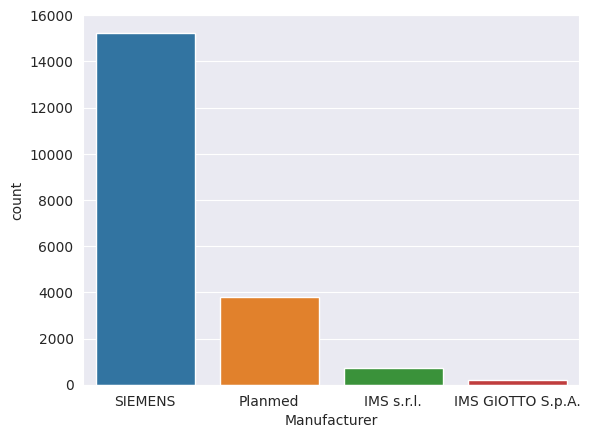

In [5]:
sns.countplot(x=meta_df["Manufacturer"])
plt.show()

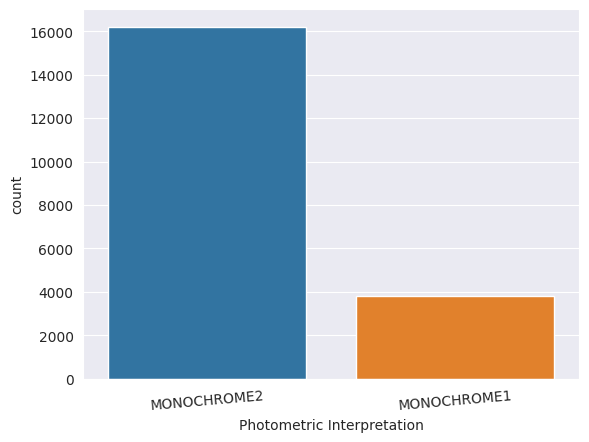

In [6]:
sns.countplot(x=meta_df["Photometric Interpretation"])
plt.xticks(rotation = 5)
plt.show()

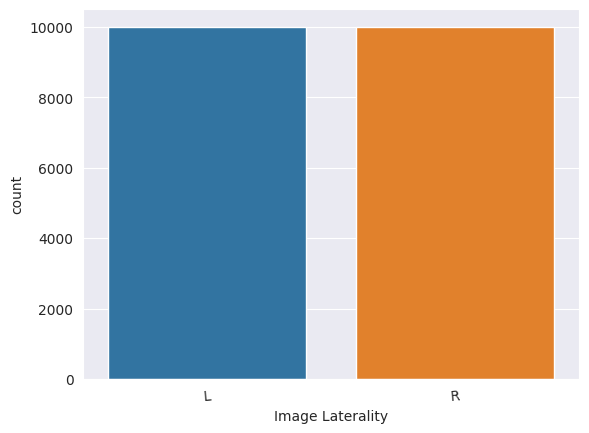

In [7]:
sns.countplot(x=meta_df["Image Laterality"])
plt.xticks(rotation = 5)
plt.show()

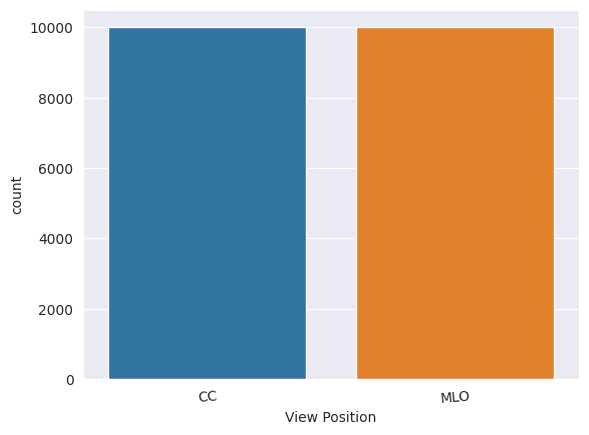

In [8]:
sns.countplot(x=meta_df["View Position"])
plt.xticks(rotation = 5)
plt.show()

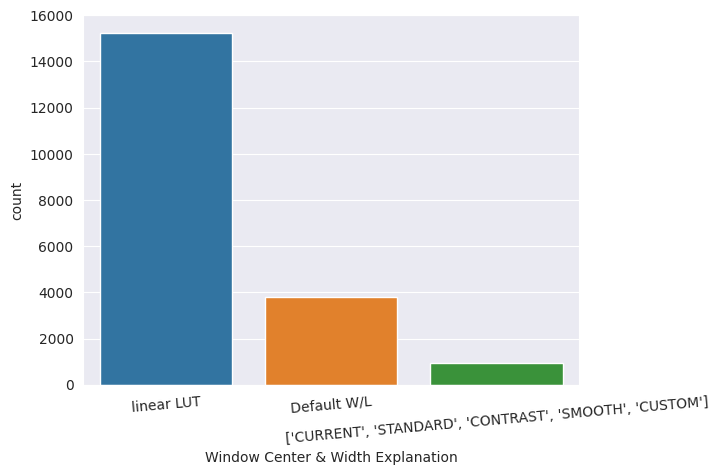

In [9]:
sns.countplot(x=meta_df["Window Center & Width Explanation"])
plt.xticks(rotation = 5)
plt.show()

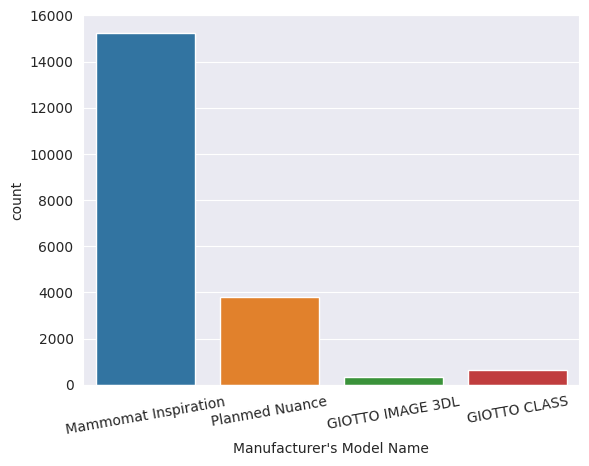

In [10]:
sns.countplot(x=meta_df["Manufacturer's Model Name"])
plt.xticks(rotation = 10)
plt.show()

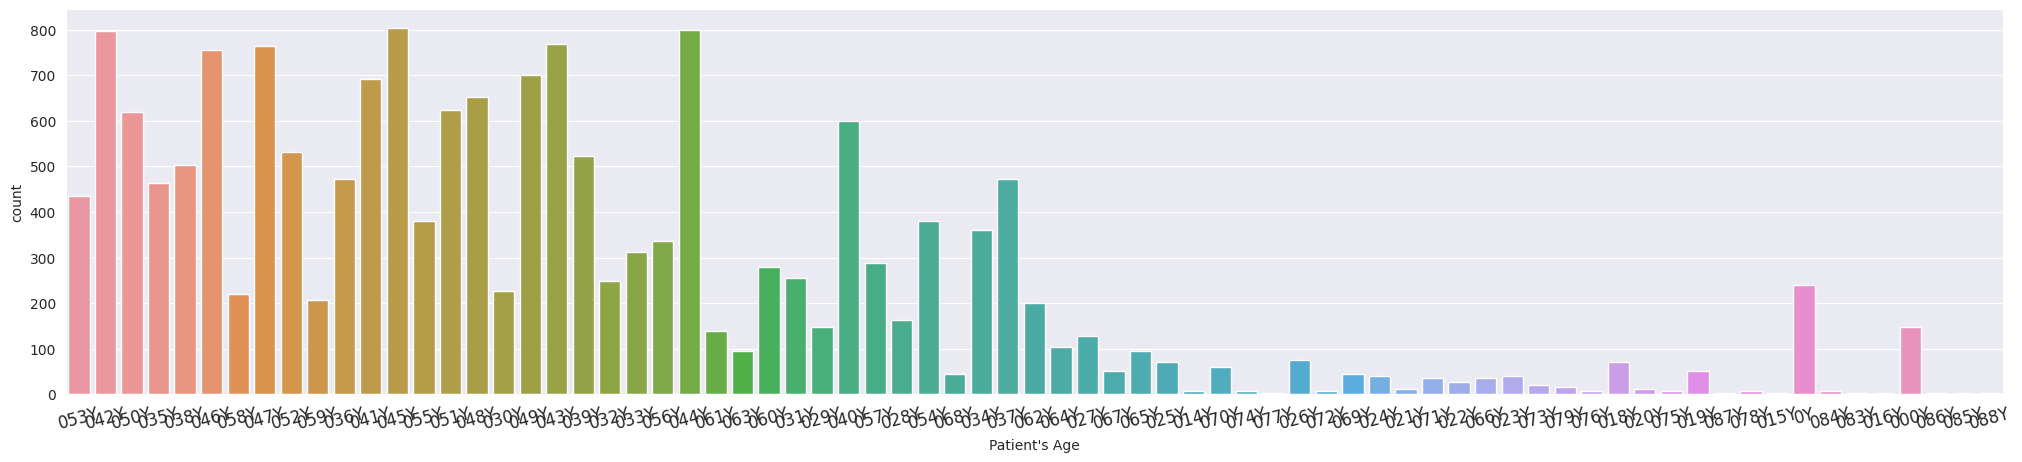

In [11]:
plt.figure(figsize=(25, 5))
sns.countplot(x=meta_df["Patient's Age"])
plt.xticks(rotation = 15, fontsize=12)
plt.show()

In [12]:
meta_df.describe().T

count         mean          std     min     25%  \
Rows                       20000.0  3386.977200   278.611866  2812.0  3518.0   
Columns                    20000.0  2647.476500   308.275842  2012.0  2800.0   
Pixel Padding Value        20000.0  1898.000000  3921.525841     0.0     0.0   
Pixel Padding Range Limit    960.0  3074.763542  1900.710503   294.0  1437.0   
Rescale Intercept          20000.0     0.000000     0.000000     0.0     0.0   
Rescale Slope              20000.0     1.000000     0.000000     1.0     1.0   

                              50%     75%      max  
Rows                       3518.0  3518.0   3580.0  
Columns                    2800.0  2800.0   2812.0  
Pixel Padding Value           0.0     0.0  10000.0  
Pixel Padding Range Limit  3034.0  4548.5   7419.0  
Rescale Intercept             0.0     0.0      0.0  
Rescale Slope                 1.0     1.0      1.0

In [13]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   SOP Instance UID                   20000 non-null  object 
 1   Series Instance UID                20000 non-null  object 
 2   SOP Instance UID.1                 20000 non-null  object 
 3   Patient's Age                      17740 non-null  object 
 4   View Position                      20000 non-null  object 
 5   Image Laterality                   20000 non-null  object 
 6   Photometric Interpretation         20000 non-null  object 
 7   Rows                               20000 non-null  int64  
 8   Columns                            20000 non-null  int64  
 9   Imager Pixel Spacing               20000 non-null  object 
 10  Pixel Spacing                      3872 non-null   object 
 11  Pixel Padding Value                20000 non-null  int

# Annotations Data 🧐

# Breast Level 

In [14]:
# https://www.cancer.org/cancer/types/breast-cancer/screening-tests-and-early-detection/mammograms/understanding-your-mammogram-report.html#:~:text=Doctors%20use%20a%20standard%20system,the%20same%20words%20and%20terms.

# BIRADS0 = Incomplete - Additional imaging evaluation and/or comparison to prior mammograms (or other imaging tests) is needed.
# BIRADS1 = negative
# BIRADS2 = Benign (non-cancerous) finding
# BIRADS3 = Probably benign finding – Follow-up in a short time frame is suggested
# BIRADS4 = Suspicious abnormality – Biopsy should be considered
# BIRADS5 = Highly suggestive of malignancy – Appropriate action should be taken
# BIRADS6 = Known biopsy-proven malignancy – Appropriate action should be taken


breast_level_df = pd.read_csv(BREAST_LEVEL_DATA)
breast_level_df.head()

study_id                         series_id  \
0  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
1  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
2  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
3  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
4  8269f5971eaca3e5d3772d1796e6bd7a  d931832a0815df082c085b6e09d20aac   

                           image_id laterality view_position  height  width  \
0  d8125545210c08e1b1793a5af6458ee2          L            CC    3518   2800   
1  290c658f4e75a3f83ec78a847414297c          L           MLO    3518   2800   
2  cd0fc7bc53ac632a11643ac4cc91002a          R            CC    3518   2800   
3  71638b1e853799f227492bfb08a01491          R           MLO    3518   2800   
4  dd9ce3288c0773e006a294188aadba8e          L            CC    3518   2800   

  breast_birads breast_density     split  
0     BI-RADS 2      DENSITY C  training  
1     BI-RADS 2      DENSITY C  training  
2     BI-RADS 2      DENSITY C  training  
3     BI-RADS 2      DENSITY C  training  
4     BI-RADS 1      DENSITY C  training

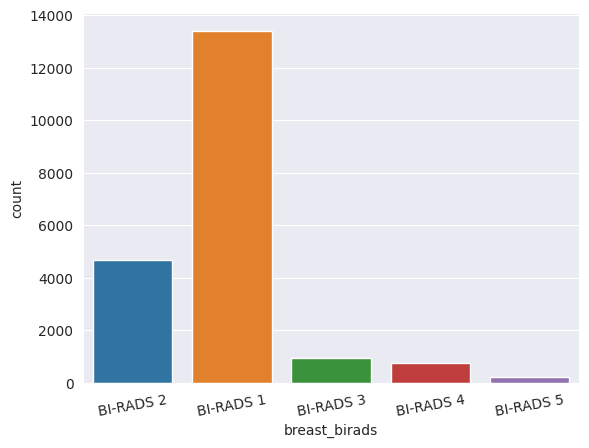

In [15]:
sns.countplot(x=breast_level_df["breast_birads"])
plt.xticks(rotation = 10)
plt.show()

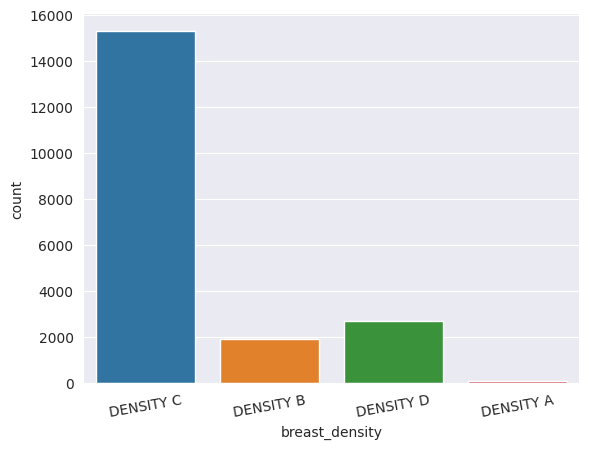

In [16]:
# https://www.breastcancer.org/risk/risk-factors/dense-breasts

# A) Mostly fatty: The breasts are made up of mostly fatty tissue and contain very little fibrous and glandular tissue. About 10% of women have fatty breasts.
# B) Scattered fibroglandular densities: The breasts are mostly fatty tissue, but there are a few areas of fibrous and glandular tissue visible on the mammogram. About 40% of women have scattered density.
# C) Heterogeneously dense: A mammogram shows many areas of fibrous and glandular tissue. About 40% of women get this result.
# D) Extremely dense: The breasts have large amounts of fibrous and glandular tissue. About 10% of women fall into this category.

# Dense breasts make it harder for doctors to see breast cancers on mammograms. This increases the risk that cancers will be missed.
# Women with dense breasts have a higher risk of developing breast cancer compared to women who don’t have dense breasts. 

sns.countplot(x=breast_level_df["breast_density"])
plt.xticks(rotation = 10)
plt.show()

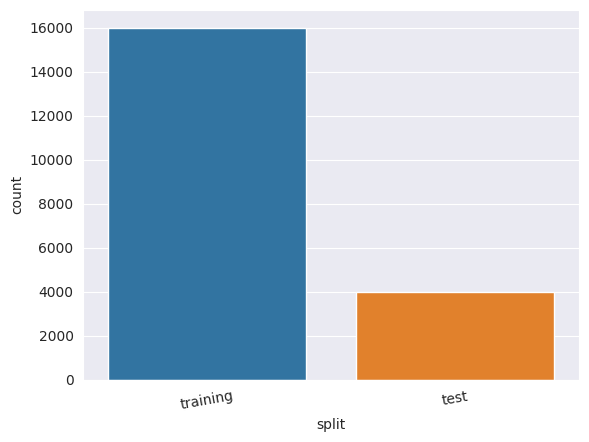

In [17]:
sns.countplot(x=breast_level_df["split"])
plt.xticks(rotation = 10)
plt.show()

## Finding Annotations

In [18]:
annotations_df = pd.read_csv(FINDING_ANNOTATIONS_DATA)
annotations_df.head()

study_id                         series_id  \
0  48575a27b7c992427041a82fa750d3fa  26de4993fa6b8ae50a91c8baf49b92b0   
1  48575a27b7c992427041a82fa750d3fa  26de4993fa6b8ae50a91c8baf49b92b0   
2  75e8e48933289d70b407379a564f8594  853b70e7e6f39133497909d9ca4c756d   
3  75e8e48933289d70b407379a564f8594  853b70e7e6f39133497909d9ca4c756d   
4  c3487424fee1bdd4515b72dc3fd69813  77619c914263eae44e9099f1ce07192c   

                           image_id laterality view_position  height  width  \
0  4e3a578fe535ea4f5258d3f7f4419db8          R            CC    3518   2800   
1  dac39351b0f3a8c670b7f8dc88029364          R           MLO    3518   2800   
2  c83f780904f25eacb44e9030f32c66e1          R            CC    3518   2800   
3  893528bc38a0362928a89364f1b692fd          R           MLO    3518   2800   
4  318264c881bf12f2c1efe5f93920cc37          R            CC    3518   2800   

  breast_birads breast_density            finding_categories finding_birads  \
0     BI-RADS 4      DENSITY C                      ['Mass']      BI-RADS 4   
1     BI-RADS 4      DENSITY C                      ['Mass']      BI-RADS 4   
2     BI-RADS 3      DENSITY C          ['Global Asymmetry']      BI-RADS 3   
3     BI-RADS 3      DENSITY C          ['Global Asymmetry']      BI-RADS 3   
4     BI-RADS 4      DENSITY C  ['Architectural Distortion']      BI-RADS 4   

          xmin         ymin         xmax         ymax     split  
0  2355.139893  1731.640015  2482.979980  1852.750000  training  
1  2386.679932  1240.609985  2501.800049  1354.040039  training  
2  2279.179932  1166.510010  2704.439941  2184.260010  training  
3  1954.270020  1443.640015  2589.760010  2193.810059  training  
4  2172.300049  1967.410034  2388.699951  2147.159912  training

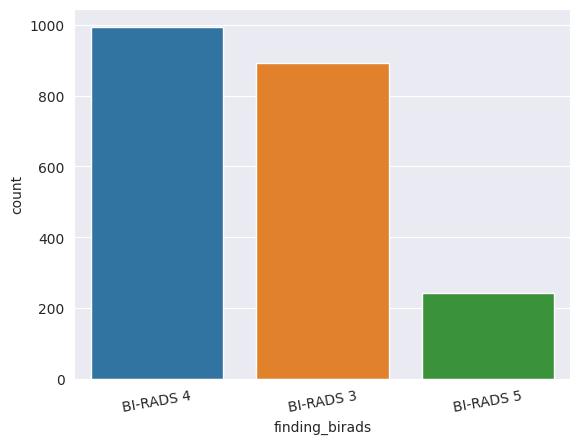

In [19]:
sns.countplot(x=annotations_df["finding_birads"])
plt.xticks(rotation = 10)
plt.show()

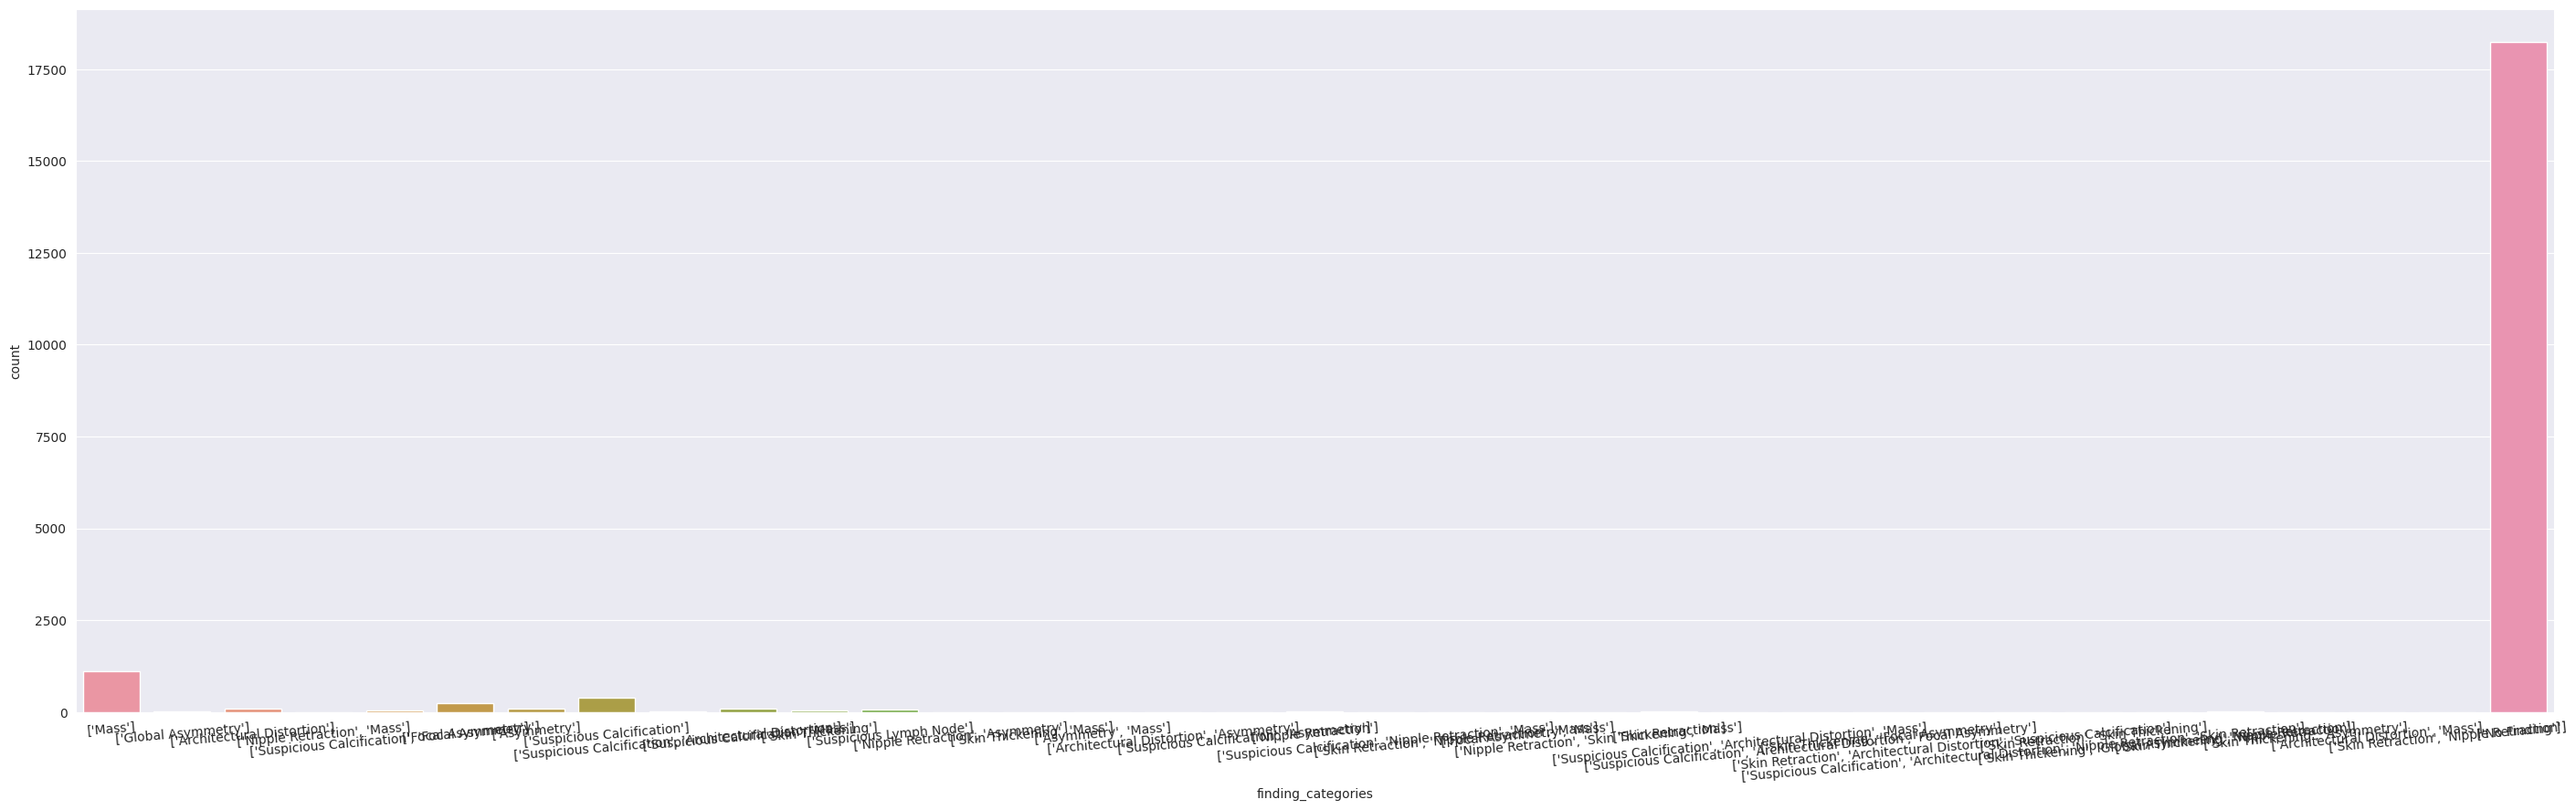

In [20]:
plt.figure(figsize=(35, 10))
sns.countplot(x=annotations_df["finding_categories"])
plt.xticks(rotation = 5)
plt.show()

In [21]:
annotations_df.describe().T

count         mean         std          min          25%  \
height  20486.0  3387.483257  278.798948  2812.000000  3518.000000   
width   20486.0  2647.495704  308.210191  2012.000000  2800.000000   
xmin     2254.0  1160.120275  960.853053   -26.844999   244.267254   
ymin     2254.0  1439.259983  444.646243    -5.224050  1165.827484   
xmax     2254.0  1426.837964  966.959392    55.005161   513.675766   
ymax     2254.0  1740.299630  437.777765   152.147003  1474.479980   

                50%          75%          max  
height  3518.000000  3518.000000  3580.000000  
width   2800.000000  2800.000000  2812.000000  
xmin     702.410004  2158.917542  2743.610107  
ymin    1448.295044  1743.442505  2613.790039  
xmax     989.629486  2458.270020  2830.149902  
ymax    1765.705017  2040.835010  2978.739990

In [22]:
annotations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20486 entries, 0 to 20485
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   study_id            20486 non-null  object 
 1   series_id           20486 non-null  object 
 2   image_id            20486 non-null  object 
 3   laterality          20486 non-null  object 
 4   view_position       20486 non-null  object 
 5   height              20486 non-null  int64  
 6   width               20486 non-null  int64  
 7   breast_birads       20486 non-null  object 
 8   breast_density      20486 non-null  object 
 9   finding_categories  20486 non-null  object 
 10  finding_birads      2129 non-null   object 
 11  xmin                2254 non-null   float64
 12  ymin                2254 non-null   float64
 13  xmax                2254 non-null   float64
 14  ymax                2254 non-null   float64
 15  split               20486 non-null  object 
dtypes: f

In [23]:
# annotations_df[annotations_df["study_id"]=="0025a5dc99fd5c742026f0b2b030d3e9"]
# path = /kaggle/input/vindr-mammo-processed-512-itu/images_processed_cv2_dicomsdl_512 / study_id / image_id

# Exploring Images

In [24]:
patient_dir = "/kaggle/input/vindr-mammo-processed-512-itu/images_processed_cv2_dicomsdl_512/" + annotations_df["study_id"][0]
[file for file in os.listdir(patient_dir)]

['072319cfb1594dff76bfa7fc9451d4b2.png',
 '4e3a578fe535ea4f5258d3f7f4419db8.png',
 '9692b67d358de4c1757ea108e1dba87f.png',
 'dac39351b0f3a8c670b7f8dc88029364.png']

In [25]:
annotations_df["study_id"][42]

'b7e4e3564d6a1e087343250e95f38ff4'

In [26]:
def load_scans(df=annotations_df, loc=42):
    patient_dir = os.path.join(ROOT_PATH, df["study_id"][loc])
    image_name = df["image_id"][loc] + ".png"
    image_path = os.path.join(patient_dir, image_name)
    slices = [plt.imread(os.path.join(patient_dir, file)) for file in os.listdir(patient_dir)]
    return slices

In [27]:
scans = load_scans()

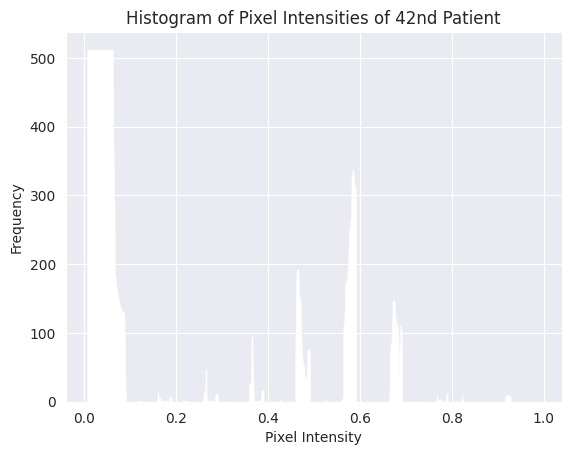

In [28]:
plt.hist(scans[0])

plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Histogram of Pixel Intensities of 42nd Patient")
plt.show()


In [29]:
meta_df.columns

Index(['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1',
       'Patient's Age', 'View Position', 'Image Laterality',
       'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing',
       'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit',
       'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope',
       'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name'],
      dtype='object')

In [30]:
means = [np.mean(scans[0]), np.mean(scans[1]), np.mean(scans[2]), np.mean(scans[3])]

In [31]:
birads1 = breast_level_df[breast_level_df["breast_birads"] == "BI-RADS 1"]
birads2 = breast_level_df[breast_level_df["breast_birads"] == "BI-RADS 2"]
birads3 = breast_level_df[breast_level_df["breast_birads"] == "BI-RADS 3"]
birads4 = breast_level_df[breast_level_df["breast_birads"] == "BI-RADS 4"]
birads5 = breast_level_df[breast_level_df["breast_birads"] == "BI-RADS 5"]

In [32]:
def calculate_image_statistics(birads_df: pd.DataFrame) -> pd.DataFrame:
    image_means = []
    image_stds = []
    image_medians = []
    image_paths = []
    image_skews = []

    for idx, b in tqdm(birads_df.iterrows(), total=len(birads_df)):
        study_id = str(b["study_id"])
        image_id = str(b["image_id"])
        patient_dir =  os.path.join(ROOT_PATH, study_id)
        image_name = image_id + ".png"
        image_path = os.path.join(patient_dir, image_name)
        b_image = plt.imread(image_path)

        image_means.append(np.mean(b_image))
        image_stds.append(np.std(b_image))
        image_medians.append(np.median(b_image))
        image_skews.append(skew(b_image, axis=None))
        image_paths.append(image_path)
        
    stats_birads = pd.DataFrame(image_means, index=birads_df, columns=["means"])
    stats_birads['stds'] = image_stds
    stats_birads['medians'] = image_medians
    stats_birads['skews'] = image_skews
    stats_birads['paths'] = image_paths
    
    return stats_birads

### BIRADS-1 Images

In [33]:
b1_image_means = []
b1_image_stds = []
b1_image_medians = []
b1_image_paths = []
b1_image_skews = []

for idx, b1 in tqdm(birads1.iterrows(), total=len(birads1)):
    study_id = str(b1["study_id"])
    image_id = str(b1["image_id"])
    patient_dir =  os.path.join(ROOT_PATH, study_id)
    image_name = image_id + ".png"
    image_path = os.path.join(patient_dir, image_name)
    b1_image = plt.imread(image_path)
    
    b1_image_means.append(np.mean(b1_image))
    b1_image_stds.append(np.std(b1_image))
    b1_image_medians.append(np.median(b1_image))
    b1_image_skews.append(skew(b1_image, axis=None))
    b1_image_paths.append(image_path)

100%|██████████| 13406/13406 [04:21<00:00, 51.32it/s]


In [34]:
stats_birads1 = pd.DataFrame(b1_image_means, index=birads1, columns=["means"])
stats_birads1['stds'] = b1_image_stds
stats_birads1['medians'] = b1_image_medians
stats_birads1['skews'] = b1_image_skews
stats_birads1['paths'] = b1_image_paths

fig = px.scatter_3d(stats_birads1, x='means', y='stds', z='skews',
              color='medians')
fig.update_layout(title='BIRADS-1 Image Statistics')
fig.show()

In [35]:
scaler = StandardScaler()
X = stats_birads1.drop(['paths'], axis=1).values
X = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=4, random_state=42)
stats_birads1["cluster_label"] = gmm.fit_predict(X)

fig = px.scatter_3d(stats_birads1, x='means', y='stds', z='skews',
              color='cluster_label')
fig.update_layout(title='BIRADS-1 Image Statistics Clusters')

fig.show()

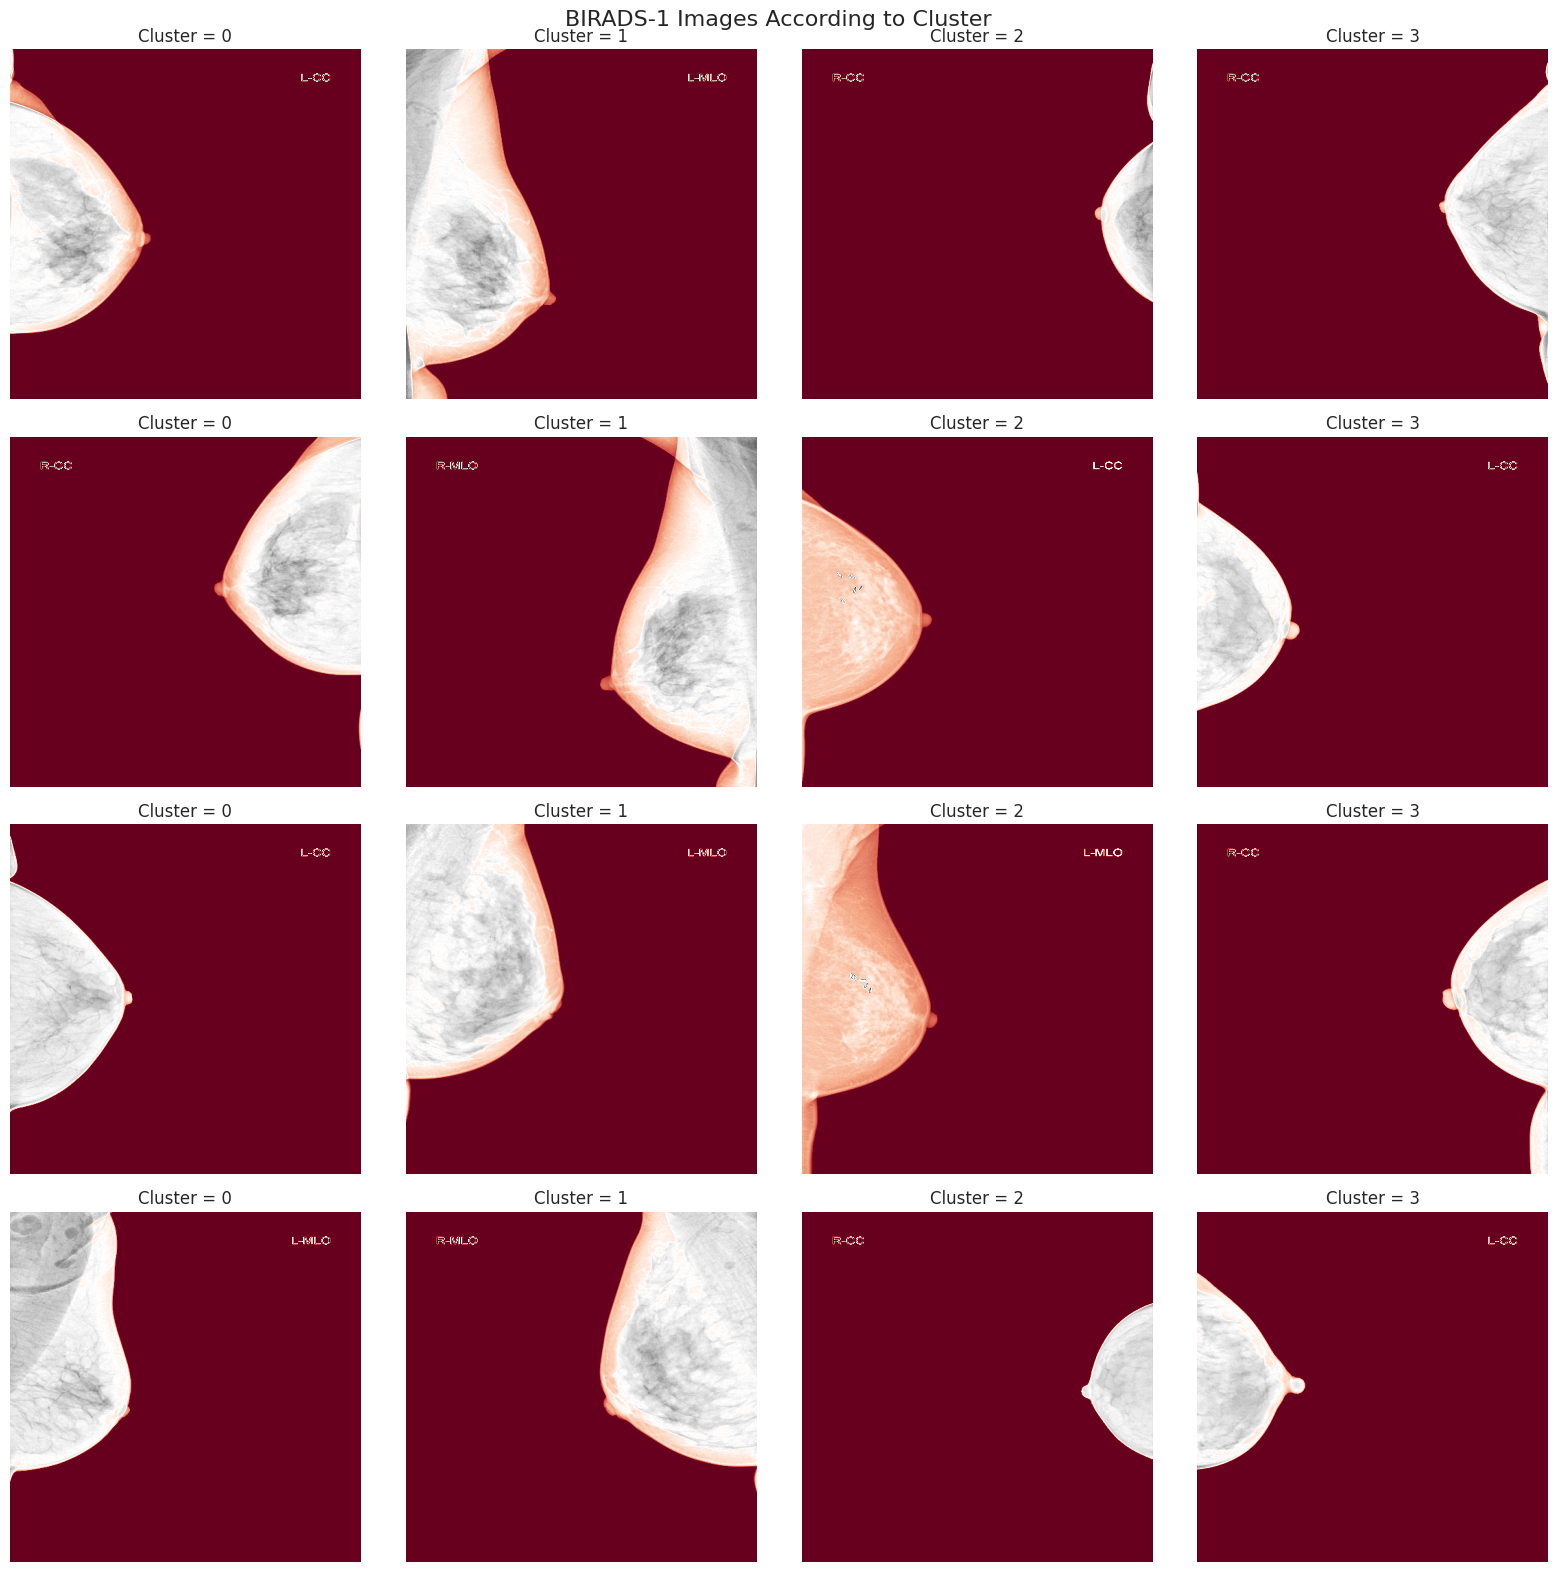

In [36]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for l in range(4):
    img_paths = stats_birads1[stats_birads1.cluster_label == l].paths.values
    for n in range(4):
        try:
            image = Image.open(img_paths[n])
            ax[n, l].imshow(image, cmap=plt.cm.RdGy)
            ax[n, l].axis('off')
            ax[n,l].set_title(f"Cluster = {l}")
        except:
            print(f"Error opening image: {img_paths[n]}, Error: {str(e)}")

plt.suptitle('BIRADS-1 Images According to Cluster', fontsize=16)
plt.tight_layout()
plt.show()

### BIRADS-2 Images

In [37]:
b2_image_means = []
b2_image_stds = []
b2_image_medians = []
b2_image_paths = []
b2_image_skews = []

for idx, b2 in tqdm(birads2.iterrows(), total=len(birads2)):
    study_id = str(b2["study_id"])
    image_id = str(b2["image_id"])
    patient_dir =  os.path.join(ROOT_PATH, study_id)
    image_name = image_id + ".png"
    image_path = os.path.join(patient_dir, image_name)
    b2_image = plt.imread(image_path)
    
    b2_image_means.append(np.mean(b2_image))
    b2_image_stds.append(np.std(b2_image))
    b2_image_medians.append(np.median(b2_image))
    b2_image_skews.append(skew(b2_image, axis=None))
    b2_image_paths.append(image_path)

100%|██████████| 4676/4676 [01:27<00:00, 53.17it/s]


In [38]:
stats_birads2 = pd.DataFrame(b2_image_means, index=birads2, columns=["means"])
stats_birads2['stds'] = b2_image_stds
stats_birads2['medians'] = b2_image_medians
stats_birads2['skews'] = b2_image_skews
stats_birads2['paths'] = b2_image_paths

fig = px.scatter_3d(stats_birads2, x='means', y='stds', z='skews',
              color='medians')
fig.update_layout(title='BIRADS-2 Image Statistics')
fig.show()

In [39]:
scaler = StandardScaler()
X = stats_birads2.drop(['paths'], axis=1).values
X = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=4, random_state=42)
stats_birads2["cluster_label"] = gmm.fit_predict(X)

fig = px.scatter_3d(stats_birads2, x='means', y='stds', z='skews',
              color='cluster_label')
fig.update_layout(title='BIRADS-2 Image Statistics Clusters')
fig.show()

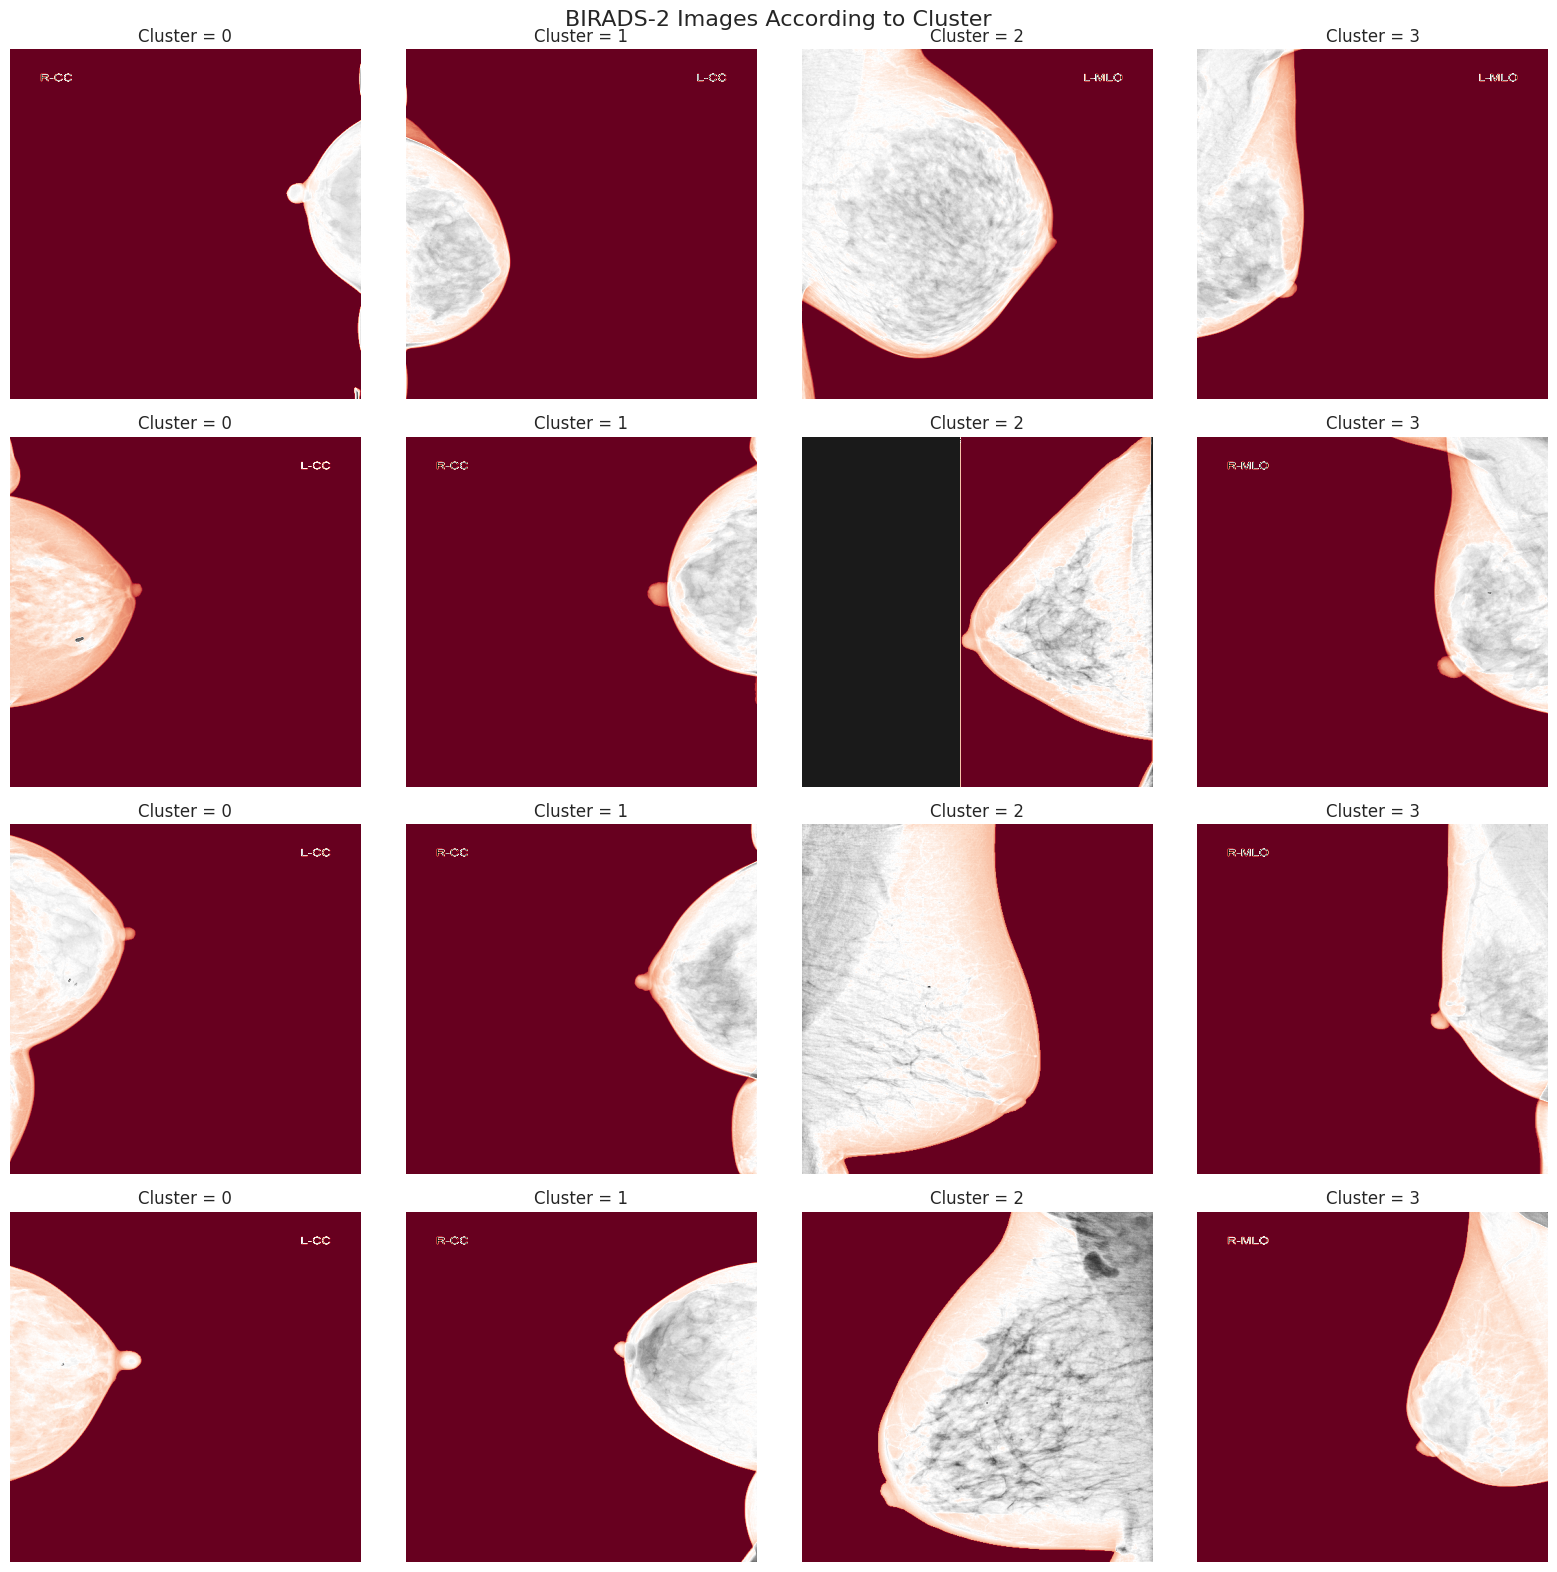

In [40]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for l in range(4):
    img_paths = stats_birads2[stats_birads2.cluster_label == l].paths.values
    for n in range(4):
        try:
            image = Image.open(img_paths[n])
            ax[n, l].imshow(image, cmap=plt.cm.RdGy)
            ax[n, l].axis('off')
            ax[n,l].set_title(f"Cluster = {l}")
        except:
            print(f"Error opening image: {img_paths[n]}, Error: {str(e)}")

plt.suptitle('BIRADS-2 Images According to Cluster', fontsize=16)
plt.tight_layout()
plt.show()

### BIRADS-3 Images

In [41]:
b3_image_means = []
b3_image_stds = []
b3_image_medians = []
b3_image_paths = []
b3_image_skews = []

for idx, b3 in tqdm(birads3.iterrows(), total=len(birads3)):
    study_id = str(b3["study_id"])
    image_id = str(b3["image_id"])
    patient_dir =  os.path.join(ROOT_PATH, study_id)
    image_name = image_id + ".png"
    image_path = os.path.join(patient_dir, image_name)
    b3_image = plt.imread(image_path)
    
    b3_image_means.append(np.mean(b3_image))
    b3_image_stds.append(np.std(b3_image))
    b3_image_medians.append(np.median(b3_image))
    b3_image_skews.append(skew(b3_image, axis=None))
    b3_image_paths.append(image_path)

100%|██████████| 930/930 [00:16<00:00, 55.85it/s]


In [42]:
stats_birads3 = pd.DataFrame(b3_image_means, index=birads3, columns=["means"])
stats_birads3['stds'] = b3_image_stds
stats_birads3['medians'] = b3_image_medians
stats_birads3['skews'] = b3_image_skews
stats_birads3['paths'] = b3_image_paths

fig = px.scatter_3d(stats_birads3, x='means', y='stds', z='skews',
              color='medians')
fig.update_layout(title='BIRADS-3 Image Statistics')
fig.show()

In [43]:
scaler = StandardScaler()
X = stats_birads3.drop(['paths'], axis=1).values
X = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=4, random_state=42)
stats_birads3["cluster_label"] = gmm.fit_predict(X)

fig = px.scatter_3d(stats_birads3, x='means', y='stds', z='skews',
              color='cluster_label')
fig.update_layout(title='BIRADS-3 Image Statistics Clusters')

fig.show()

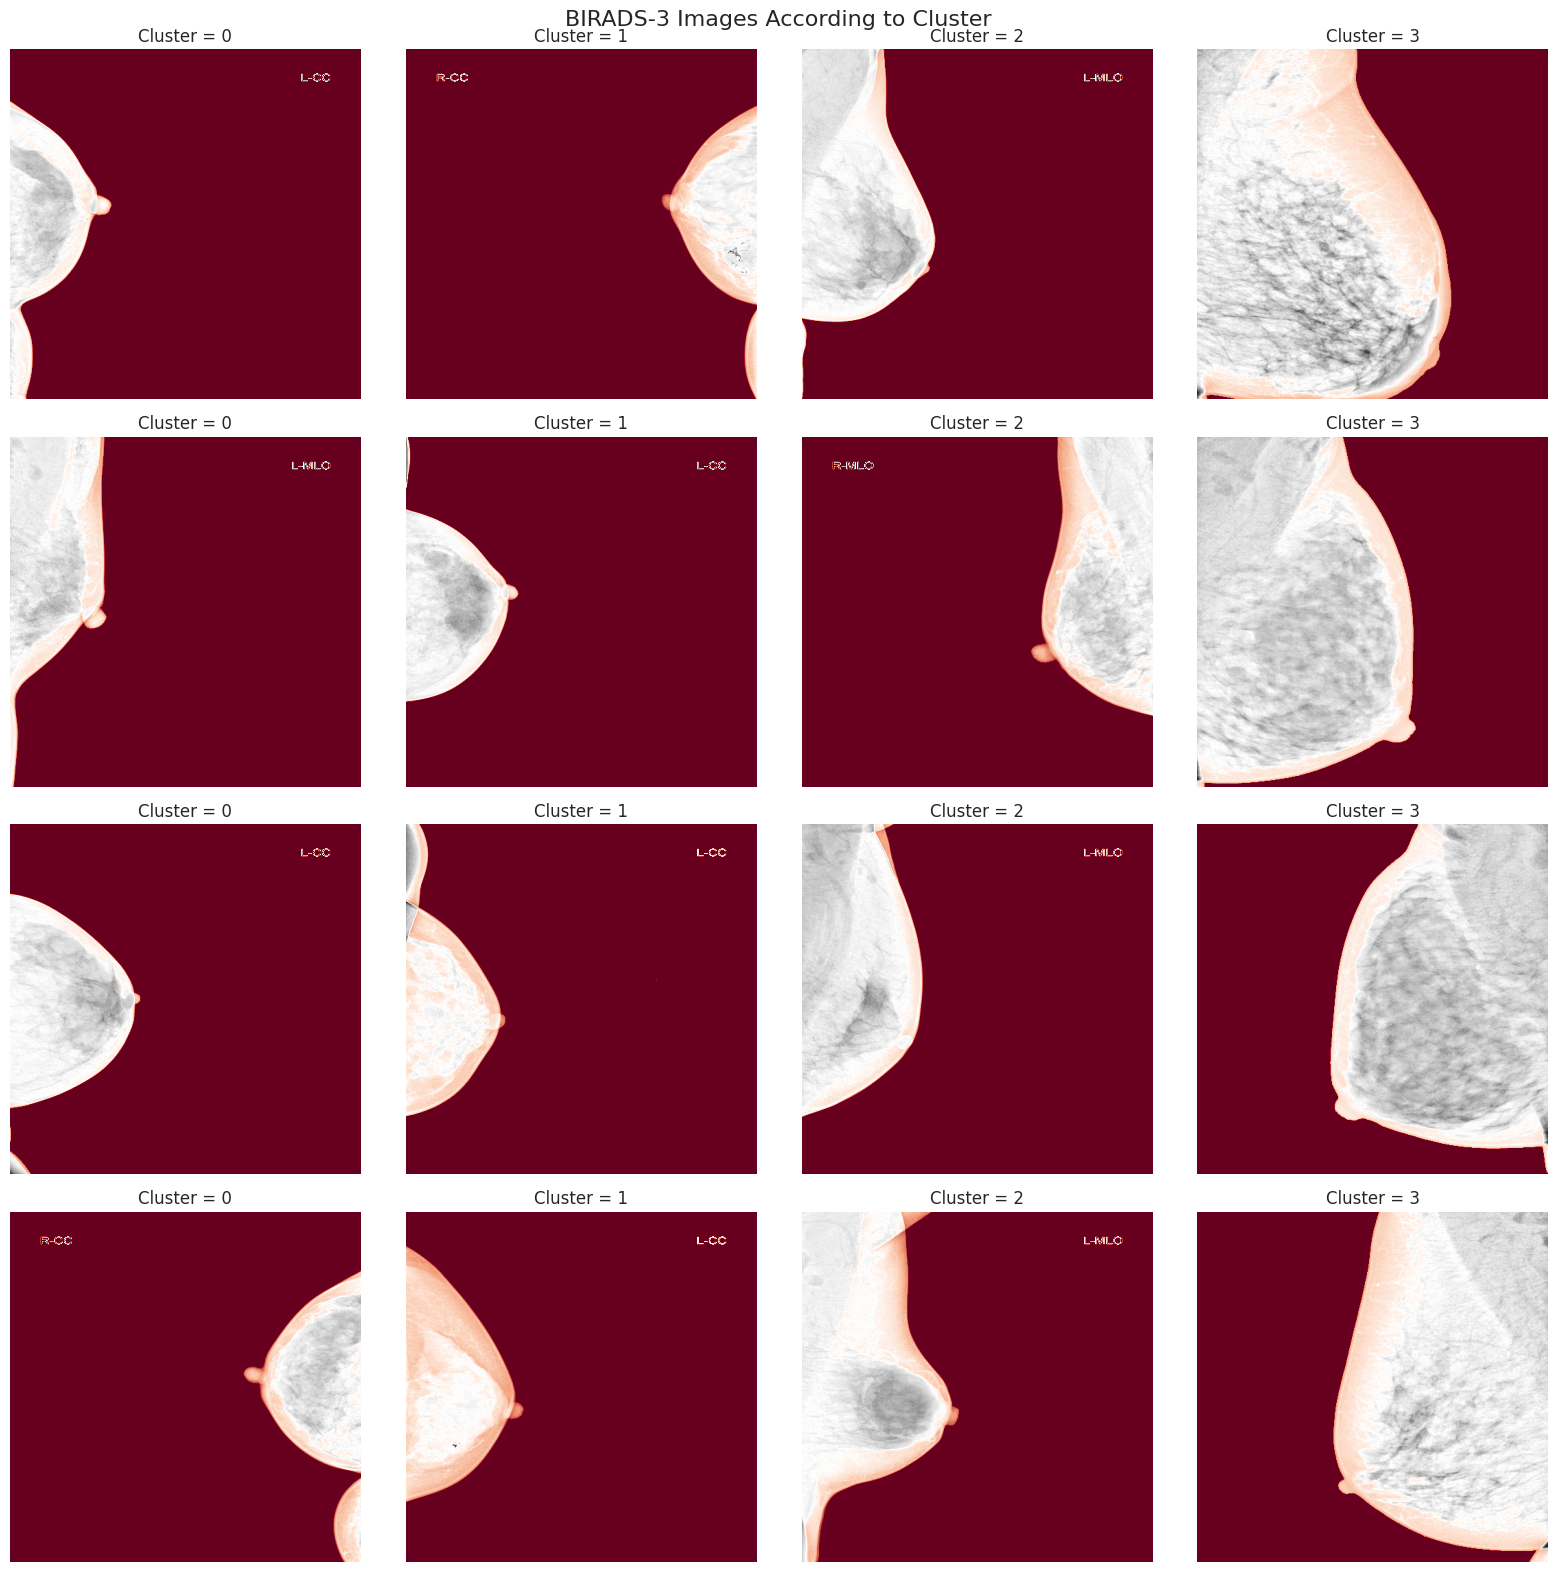

In [44]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for l in range(4):
    img_paths = stats_birads3[stats_birads3.cluster_label == l].paths.values
    for n in range(4):
        try:
            image = Image.open(img_paths[n])
            ax[n, l].imshow(image, cmap=plt.cm.RdGy)
            ax[n, l].axis('off')
            ax[n,l].set_title(f"Cluster = {l}")
        except:
            print(f"Error opening image: {img_paths[n]}, Error: {str(e)}")

plt.suptitle('BIRADS-3 Images According to Cluster', fontsize=16)
plt.tight_layout()
plt.show()

### BIRADS-4 Images

In [45]:
b4_image_means = []
b4_image_stds = []
b4_image_medians = []
b4_image_paths = []
b4_image_skews = []

for idx, b4 in tqdm(birads4.iterrows(), total=len(birads4)):
    study_id = str(b4["study_id"])
    image_id = str(b4["image_id"])
    patient_dir =  os.path.join(ROOT_PATH, study_id)
    image_name = image_id + ".png"
    image_path = os.path.join(patient_dir, image_name)
    b4_image = plt.imread(image_path)
    
    b4_image_means.append(np.mean(b4_image))
    b4_image_stds.append(np.std(b4_image))
    b4_image_medians.append(np.median(b4_image))
    b4_image_skews.append(skew(b4_image, axis=None))
    b4_image_paths.append(image_path)

100%|██████████| 762/762 [00:14<00:00, 53.62it/s]


In [46]:
stats_birads4 = pd.DataFrame(b4_image_means, index=birads4, columns=["means"])
stats_birads4['stds'] = b4_image_stds
stats_birads4['medians'] = b4_image_medians
stats_birads4['skews'] = b4_image_skews
stats_birads4['paths'] = b4_image_paths

fig = px.scatter_3d(stats_birads4, x='means', y='stds', z='skews',
              color='medians')
fig.update_layout(title='BIRADS-4 Image Statistics')
fig.show()

In [47]:
scaler = StandardScaler()
X = stats_birads4.drop(['paths'], axis=1).values
X = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=4, random_state=42)
stats_birads4["cluster_label"] = gmm.fit_predict(X)

fig = px.scatter_3d(stats_birads4, x='means', y='stds', z='skews',
              color='cluster_label')
fig.update_layout(title='BIRADS-4 Image Statistics Clusters')

fig.show()

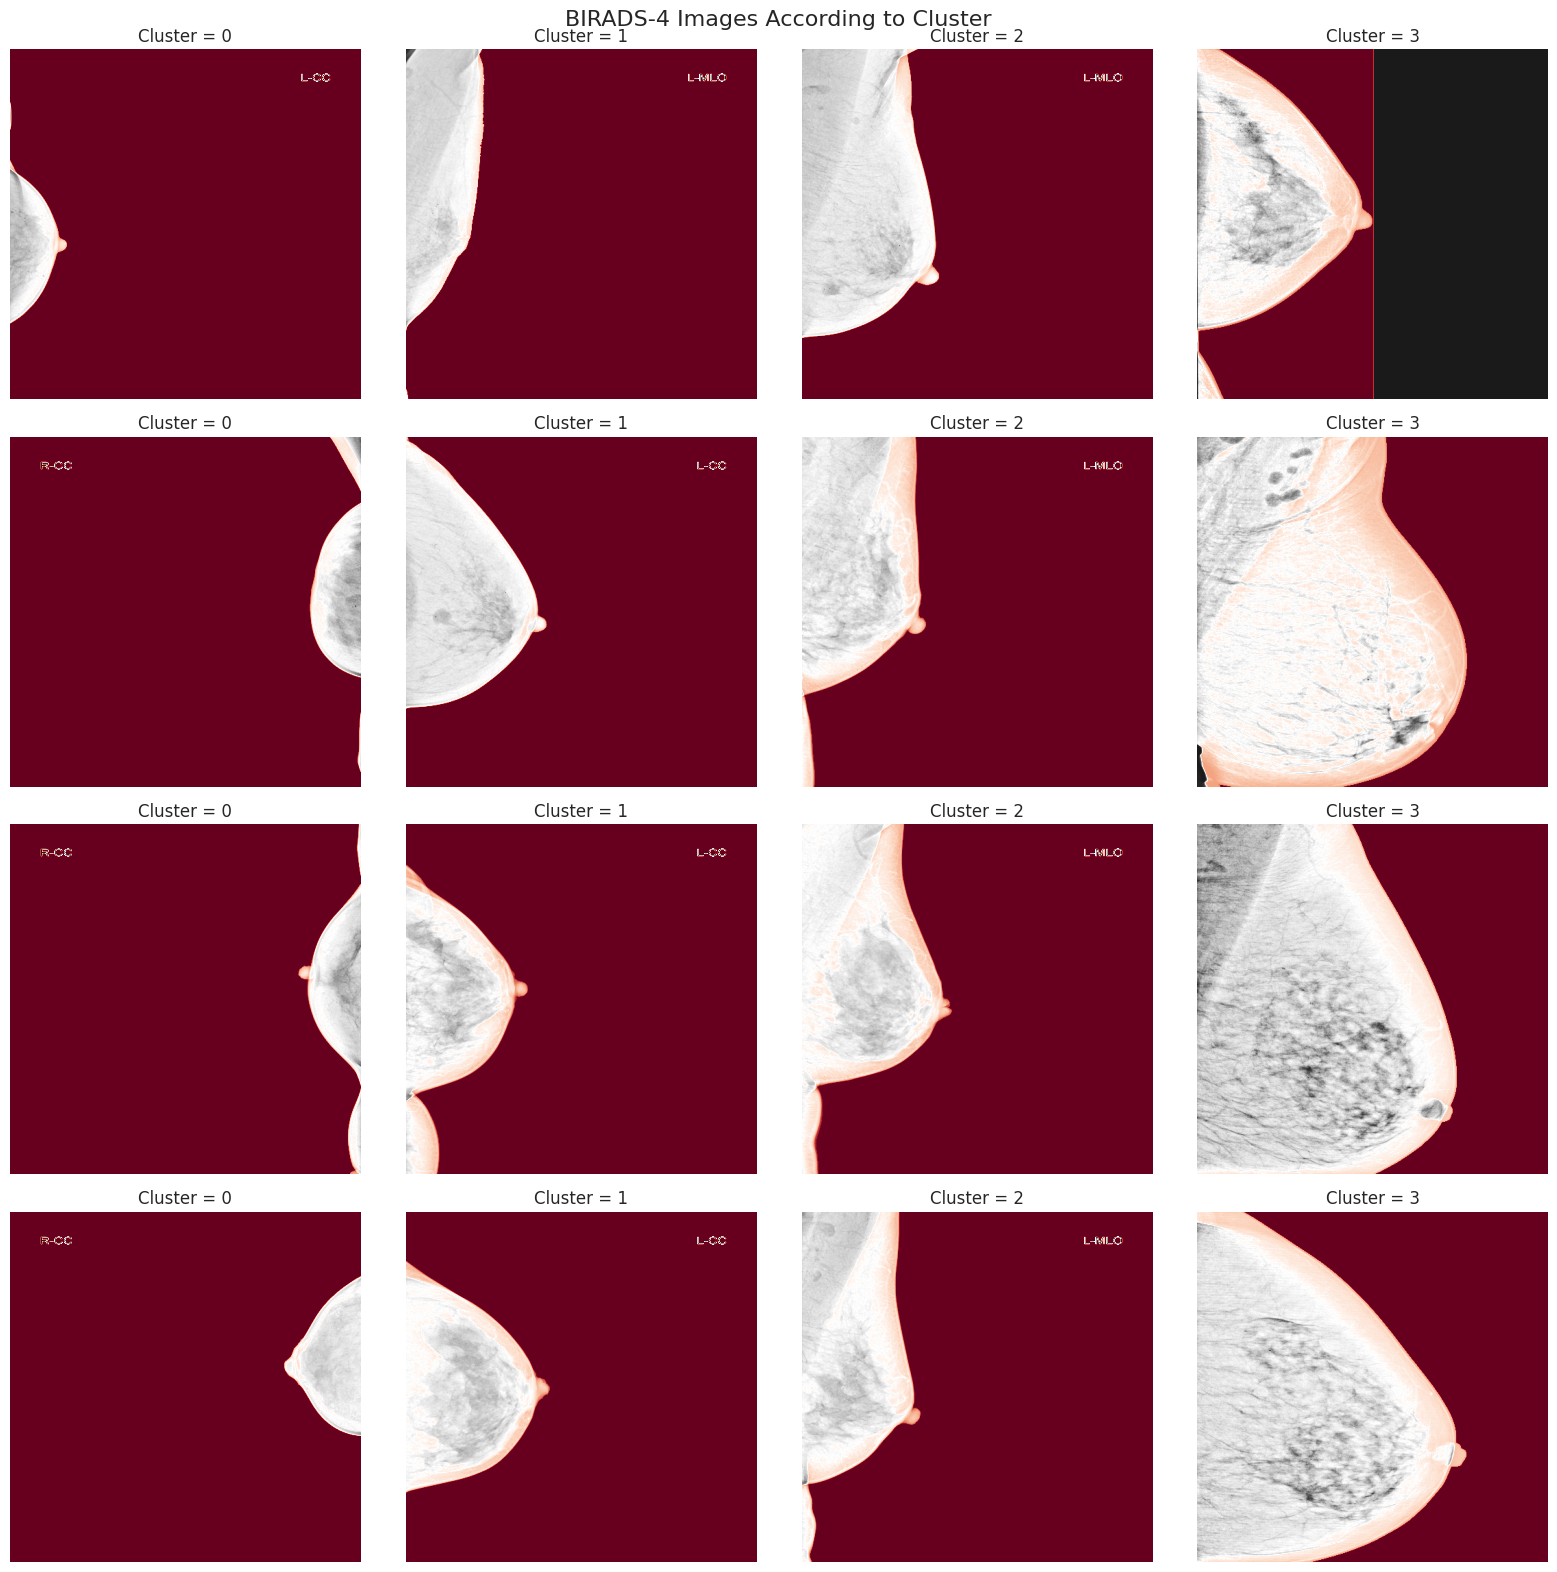

In [48]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for l in range(4):
    img_paths = stats_birads4[stats_birads4.cluster_label == l].paths.values
    for n in range(4):
        try:
            image = Image.open(img_paths[n])
            ax[n, l].imshow(image, cmap=plt.cm.RdGy)
            ax[n, l].axis('off')
            ax[n,l].set_title(f"Cluster = {l}")
        except:
            print(f"Error opening image: {img_paths[n]}, Error: {str(e)}")

plt.suptitle('BIRADS-4 Images According to Cluster', fontsize=16)
plt.tight_layout()
plt.show()

### BIRADS-5 Images

In [49]:
b5_image_means = []
b5_image_stds = []
b5_image_medians = []
b5_image_paths = []
b5_image_skews = []

for idx, b5 in tqdm(birads5.iterrows(), total=len(birads5)):
    study_id = str(b5["study_id"])
    image_id = str(b5["image_id"])
    patient_dir =  os.path.join(ROOT_PATH, study_id)
    image_name = image_id + ".png"
    image_path = os.path.join(patient_dir, image_name)
    b5_image = plt.imread(image_path)
    
    b5_image_means.append(np.mean(b5_image))
    b5_image_stds.append(np.std(b5_image))
    b5_image_medians.append(np.median(b5_image))
    b5_image_skews.append(skew(b5_image, axis=None))
    b5_image_paths.append(image_path)

100%|██████████| 226/226 [00:04<00:00, 54.32it/s]


In [50]:
stats_birads5 = pd.DataFrame(b5_image_means, index=birads5, columns=["means"])
stats_birads5['stds'] = b5_image_stds
stats_birads5['medians'] = b5_image_medians
stats_birads5['skews'] = b5_image_skews
stats_birads5['paths'] = b5_image_paths

fig = px.scatter_3d(stats_birads5, x='means', y='stds', z='skews',
              color='medians')
fig.update_layout(title='BIRADS-5 Image Statistics')
fig.show()

In [51]:
scaler = StandardScaler()
X = stats_birads5.drop(['paths'], axis=1).values
X = scaler.fit_transform(X)

gmm = GaussianMixture(n_components=4, random_state=42)
stats_birads5["cluster_label"] = gmm.fit_predict(X)

fig = px.scatter_3d(stats_birads5, x='means', y='stds', z='skews',
              color='cluster_label')
fig.update_layout(title='BIRADS-5 Image Statistics Clusters')

fig.show()

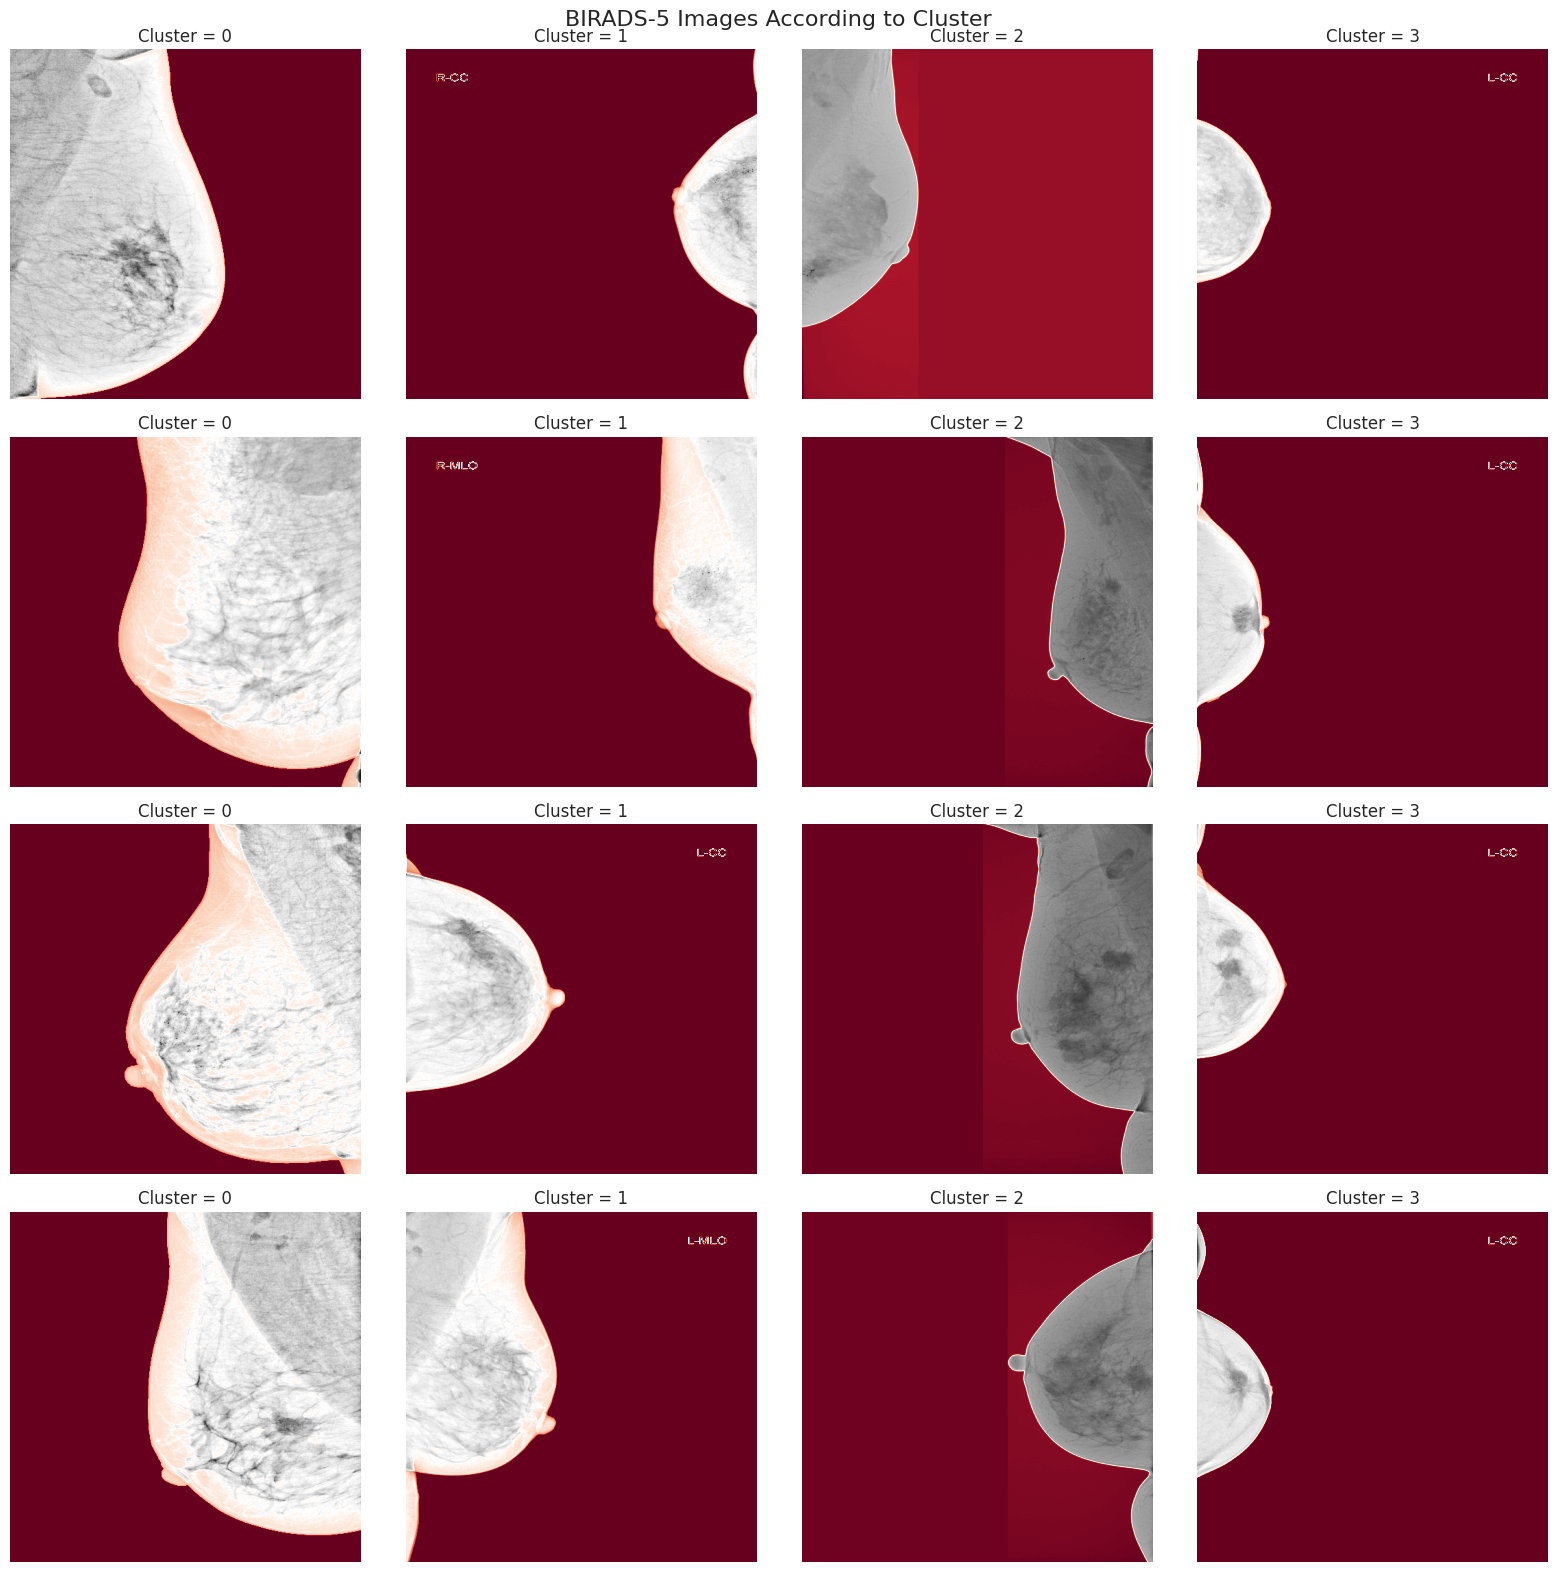

In [52]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for l in range(4):
    img_paths = stats_birads5[stats_birads5.cluster_label == l].paths.values
    for n in range(4):
        try:
            image = Image.open(img_paths[n])
            ax[n, l].imshow(image, cmap=plt.cm.RdGy)
            ax[n, l].axis('off')
            ax[n,l].set_title(f"Cluster = {l}")
        except:
            print(f"Error opening image: {img_paths[n]}, Error: {str(e)}")

plt.suptitle('BIRADS-5 Images According to Cluster', fontsize=16)
plt.tight_layout()
plt.show()